# Adaptive Kramers chains rescaled

Here we want to see if the longest relaxation time is given by (Doyle et al. 1997):

$$
Wi = 0.0142 N^2 Pe
$$

In fact we are interested in whether we see a coil-stretch transition at $Wi=0.5$. It seems to be the case if we consider the coil-stretch transition as a change in order of magnitude of polymer extention. In terms of number of links $N$, at equilibirum $\langle R^2\rangle \sim N$, and fully stretch $\langle R^2\rangle \sim N^2$. So we define the coil-stretch transistion happening for $Wi$ so that $\langle R^2\rangle \sim N^{3/2}$.


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain

## Parameters definition

In [2]:
n_links = 64       # Number of segments in the Kramers chain
n_ensemble = 16     # Number of molecules to simulate
n_proc = 4         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
seq = np.random.SeedSequence(2022)
seeds = seq.spawn(n_ensemble)
# Starting vectors
molecules = [AdaptiveKramersChain.from_normal_distribution(n_links, seed)
             for seed in seeds]

## Initial relaxation
Thermalisation step.

In [4]:
gradU = np.zeros((3, 3))
n_steps = 2000     # Number of time steps to record
dt = .01           # Time step value (dimensionless)
write_interval = 100
observables, molecules_out = simulate_batch(molecules, gradU, dt, n_steps, write_interval=write_interval, n_proc=n_proc)

Physical time to compute: 20.0
Calculation started on 4 cores.


100%|███████████████████████████████████████████| 16/16 [00:05<00:00,  2.78it/s]


We can investigate the chains distribution.

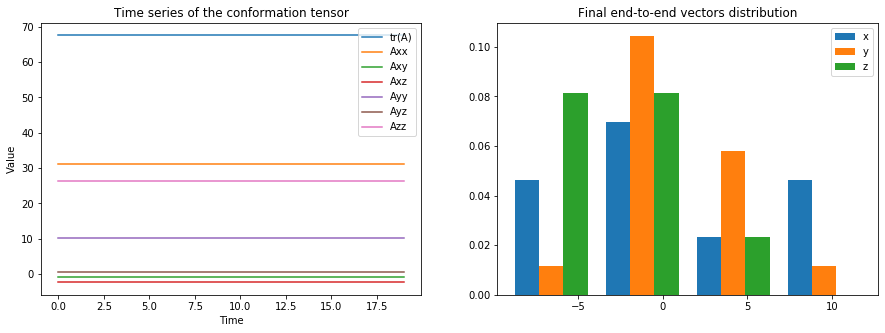

In [5]:
t = np.arange(n_steps//write_interval)*dt*write_interval
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [6]:
from scipy.interpolate import interp1d

# series of Weissenberg numbers
Wis = np.linspace(0.45, 0.55, 3)
# Hence Péclet numbers
Pes = Wis/(0.0142*n_links**2)
# Hencky strain
H = 10

t_base = []
gradU_base = []
t0 = 0
for Pe in Pes:
    t_base.append(t0)
    gradU_base.append(Pe*np.diag([1, -.5, -.5]))
    t0 = t0 + H/Pe
t_base.append(t0)
gradU_base.append(Pes[-1]*np.diag([1, -.5, -.5]))
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [7]:
n_steps = int(t0/dt)
dt = .01           
write_interval = 100
print(f"Length of time series: {n_steps//write_interval}")
observables, molecules_out = simulate_batch(molecules_out, gradU, dt, n_steps, write_interval=write_interval, n_proc=n_proc)

Length of time series: 3513
Physical time to compute: 3513.29
Calculation started on 4 cores.


  0%|                                                    | 0/16 [00:39<?, ?it/s]Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):



KeyboardInterrupt: 

In [ ]:
t = np.arange(n_steps//write_interval)*dt*write_interval
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].semilogy(t, trA, label='tr(A)')
#ax[0].semilogy(t, A[:,0,0], label='Axx')
#ax[0].semilogy(t, A[:,0,1], label='Axy')
#ax[0].semilogy(t, A[:,0,2], label='Axz')
#ax[0].semilogy(t, A[:,1,1], label='Ayy')
#ax[0].semilogy(t, A[:,1,2], label='Ayz')
#ax[0].semilogy(t, A[:,2,2], label='Azz')
ax[0].axhline(n_links**2, ls='--', label='$N^2$')
ax[0].axhline(n_links**1.5, ls=':', label='$N^{1.5}$')
ax[0].axhline(n_links, label='$N$')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
#ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
#ax[1].legend()
#ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

In [ ]:
gradUt = gradU(t)
plt.plot(gradUt[:,0,0], trA, '.', alpha=0.002)
plt.axhline(n_links**1.5, ls=':', label='$N^{1.5}$')

In [ ]:
0.52/0.5*0.0142

We can see that the average square length, tr(A), is constraint by (n_links)².

## Stress
We now examine the stress tensor.

In [ ]:
S = observables['S_average']
trS = np.trace(S, axis1=1, axis2=2)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].semilogy(t, trS, label='tr(S)')
ax[0].semilogy(t, S[:,0,0], label='Sxx)')
ax[0].set_title('Log Trace Stress')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].plot(t, S[:,0,0], label='Sxx')
ax[1].plot(t, S[:,0,1], label='Sxy')
ax[1].plot(t, S[:,1,1], label='Syy')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_title('Stress tensor')
plt.show()

A few remarks:
1. The stress is composed of a viscous part and visco-elastic part. When the flow is turned off, the viscous part vanishes instantaneously, while the viscoelastic part is relaxed over time.
2. The noise is very important with this estimator due to the rigid constaint.

In [ ]:
0.5/0.55*0.0148